In [67]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import noise


In [68]:
class Creature(Agent):
    def __init__(self, unique_id, model, trait=None, mutation_rate=0.01):
       super().__init__(unique_id, model)
       self.trait = trait if trait is not None else model.random.random() # Assign a single trait to each agent
       self.environment_factor = model.environment_factor
       self.mutation_rate = mutation_rate
        
    def move(self):
        # Get the current environmental factor
        current_environment_factor = self.model.environment_grid[self.pos[0]][self.pos[1]]

        # Get the environmental factors of the neighboring cells
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        neighbor_environment_factors = [self.model.environment_grid[pos[0]][pos[1]] for pos in neighborhood]

        # If the current environmental factor is higher than the lowest neighboring environmental factor, move to the neighboring cell with the lowest environmental factor
        if current_environment_factor > min(neighbor_environment_factors):
            min_environment_factor_pos = neighborhood[neighbor_environment_factors.index(min(neighbor_environment_factors))]
            self.model.grid.move_agent(self, min_environment_factor_pos)
            
    def step(self):
        self.move()
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighbor_traits = [neighbor.trait for neighbor in neighbors]
        
        # Calculate the average trait of the neighbors
        avg_neighbor_trait = np.mean(neighbor_traits) if neighbors else self.trait
        
        # Calculate the difference between the agent's trait and the average trait of the neighbors
        trait_difference = avg_neighbor_trait - self.trait
        
        # Update the agent's trait based on the trait difference, environmental factor, and mutation rate
        self.trait += self.model.selection_pressure * 0.1 * trait_difference * self.environment_factor
        
        # Introduce mutation: Randomly change the agent's trait with a certain probability (mutation rate)
        if self.model.random.random() < self.mutation_rate:
           self.trait += self.model.random.normalvariate(0, 0.1) # You can adjust the mutation magnitude

In [69]:
class EvolutionModel(Model):
    def __init__(self, N, width, height, environment_factor, mutation_rate, selection_pressure, initial_traits=None,terrain=None):
       self.num_agents = N
       self.grid = MultiGrid(width, height, True)
       self.schedule = RandomActivation(self)
       self.environment_factor = environment_factor
       self.mutation_rate = mutation_rate
       self.selection_pressure = selection_pressure
       self.environment_grid = terrain if terrain is not None else np.random.normal(0.5, 0.1, (width, height)) # Create a grid of environmental factors

       # If initial traits are provided, each agent is assigned one of the predefined traits
       if initial_traits:
           for i in range(self.num_agents):
               agent_trait = initial_traits[i % len(initial_traits)]
               agent = Creature(i, self, trait=agent_trait, mutation_rate=mutation_rate)
               x = np.random.choice(self.grid.width)
               y = np.random.choice(self.grid.height)
               self.grid.place_agent(agent, (x, y))
               self.schedule.add(agent)
       else:
           # If no initial traits are provided, create agents with random traits
           for i in range(self.num_agents):
               agent = Creature(i, self, mutation_rate=mutation_rate)
               x = np.random.choice(self.grid.width)
               y = np.random.choice(self.grid.height)
               self.grid.place_agent(agent, (x, y))
               self.schedule.add(agent)

       self.datacollector = DataCollector(agent_reporters={"x": lambda a: a.pos[0], 
                                                        "y": lambda a: a.pos[1], 
                                                        "Trait": lambda a: a.trait, # Report only one trait
                                                        "Environment Factor": "environment_factor"})

    def step(self):
        # Update the environment grid
          # Add random noise to simulate environmental changes
        self.environment_grid = np.clip(self.environment_grid, 0, 1)  # Ensure environmental factors stay within the range [0, 1]
        self.datacollector.collect(self)
        self.schedule.step()

In [70]:
# def generate_terrain(width, height, complexity=5, scale=50, new_min=0.2, new_max=0.5):
#     terrain = np.zeros((width, height))
# 
#     for i in range(width):
#         for j in range(height):
#             terrain[i][j] = np.sin(i / scale * complexity) + np.sin(j / scale * complexity)
# 
#     # Normalize the values to the new range [new_min, new_max]
#     terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain)) * (new_max - new_min) + new_min
# 
#     return terrain
# 
# # Example usage:
# width = 500
# height = 500
# terrain = generate_terrain(width, height, complexity=20, scale=100, new_min=0.2, new_max=0.5)
# 
# # Visualize the terrain
# plt.imshow(terrain, cmap='viridis', origin='lower')
# plt.colorbar(label='Terrain Value')
# plt.title('Generated Terrain')
# plt.show()


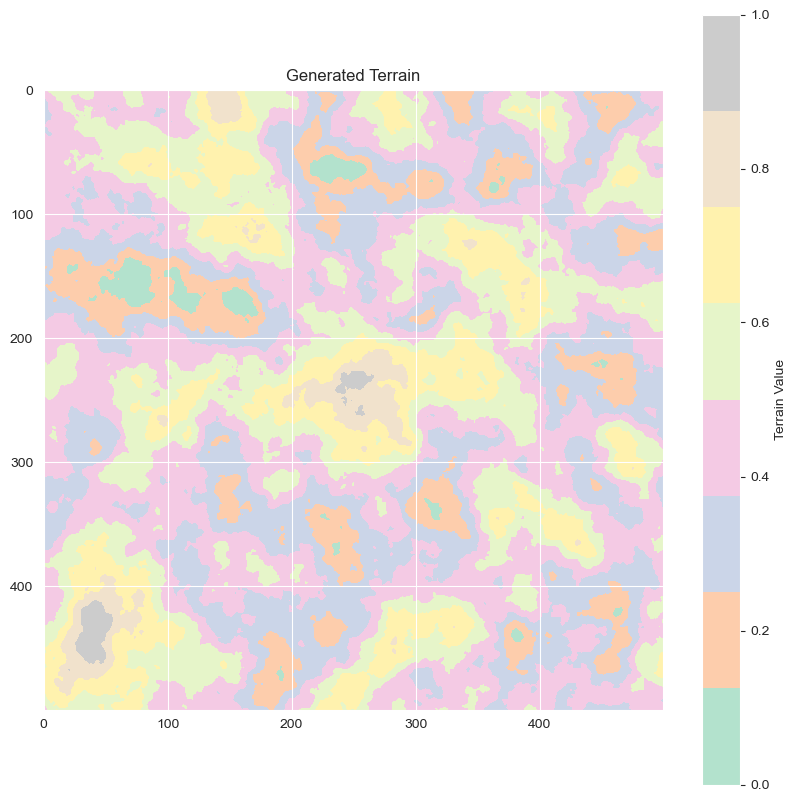

In [71]:
def generate_terrain(width, height, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0):
    terrain = np.zeros((width, height))

    for i in range(width):
        for j in range(height):
            terrain[i][j] = noise.pnoise2(i/scale, j/scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=1024, repeaty=1024, base=42)

    # Normalize the values to the range [0, 1]
    terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain))

    return terrain

def display_terrain(terrain):
    plt.figure(figsize=(10, 10))
    plt.imshow(terrain, cmap='Pastel2')
    plt.colorbar(label='Terrain Value')
    plt.title('Generated Terrain')
    plt.show()
    
width = 500
height = 500    
terrain = generate_terrain(width, height, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0)
display_terrain(terrain)


In [72]:
# Run the model for a certain number of steps
user_defined_environment_factor = 0.09
user_defined_mutation_rate = 0.01
user_defined_initial_traits = [0.1, 0.9, 0.6]
user_defined_selection_pressure = 0.7
N_steps = 100# Increase this to get a longer time series
N_agents = 10000
width = 500
height = 500


model = EvolutionModel(N_agents, width, height, user_defined_environment_factor, user_defined_mutation_rate, user_defined_selection_pressure, initial_traits=user_defined_initial_traits,terrain=terrain)
for i in range(N_steps):
    model.step()
# print(f"Number of steps in the model: {model.schedule.steps}")
# Extract and visualize data collected during the simulation
agent_data = model.datacollector.get_agent_vars_dataframe()
# print(f"Number of rows in agent_data: {len(agent_data)}")
# print(agent_data)
# Get data for the last step
last_step_data = agent_data.xs(N_steps-1, level="Step")

# Unstack the data for plotting
unstacked_data = last_step_data.unstack()

Step
0     0.533290
1     0.533229
2     0.533366
3     0.533317
4     0.533131
        ...   
95    0.533467
96    0.533417
97    0.533452
98    0.533432
99    0.533446
Name: Trait, Length: 100, dtype: float64
                x    y     Trait  Environment Factor
Step AgentID                                        
0    0        399  267  0.100000                0.09
     1        384  344  0.900000                0.09
     2        317  462  0.600000                0.09
     3         11  381  0.100000                0.09
     4        198  357  0.900000                0.09
...           ...  ...       ...                 ...
99   9995       8  144  0.483527                0.09
     9996      38  298  0.255060                0.09
     9997     166  314  0.782226                0.09
     9998     119  478  0.638406                0.09
     9999     148  376  0.103150                0.09

[1000000 rows x 4 columns]


Text(0.5, 1.0, 'Evolution Simulation Trait average over Time')

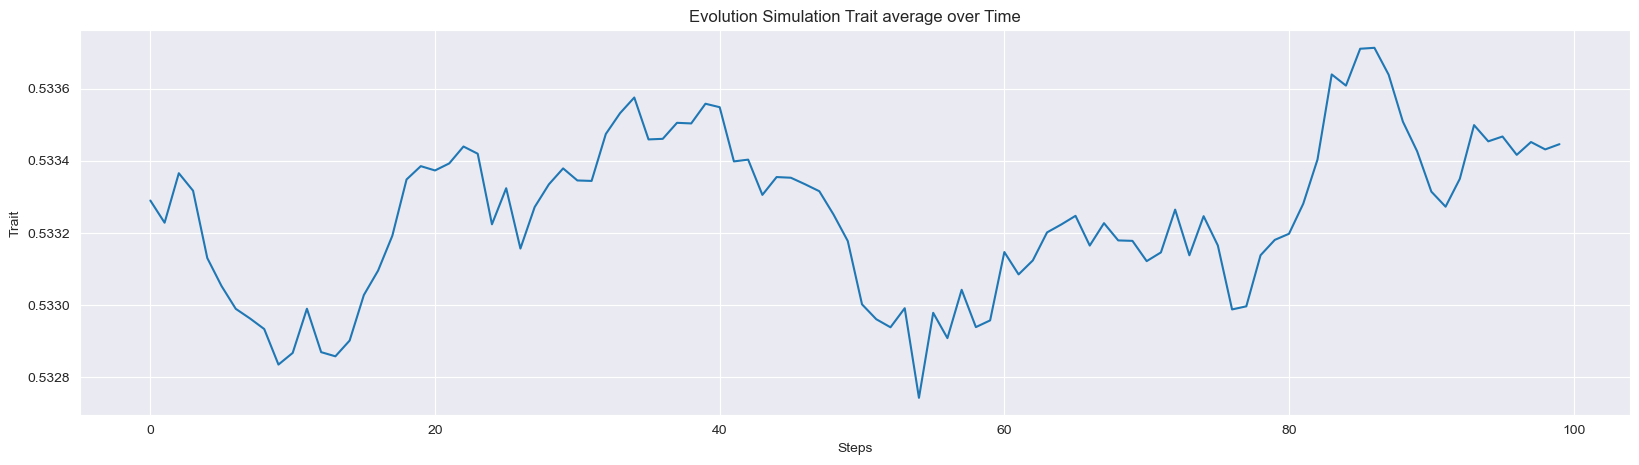

In [73]:
# Plot the trait of the agents
average_traits = agent_data.groupby("Step")['Trait'].mean()
print(average_traits)
plt.figure(figsize=(20, 5))
print(agent_data)
average_traits.plot()
plt.xlabel('Steps')
plt.ylabel('Trait')
plt.title(f'Evolution Simulation Trait average over Time')

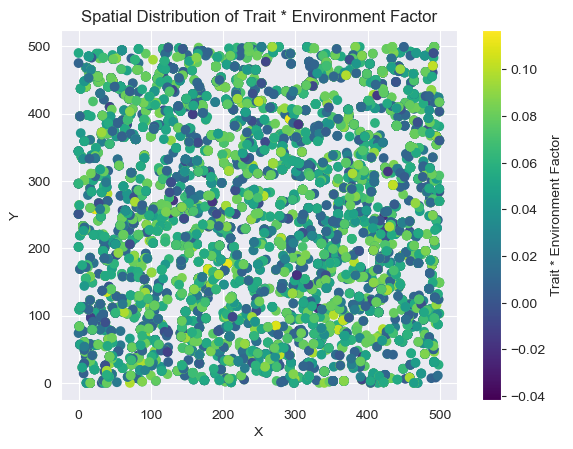

In [74]:
# Visualize the spatial distribution of the trait and environmental factors in the last step
fig, ax = plt.subplots()
sc = ax.scatter(last_step_data["x"], last_step_data["y"], c=last_step_data["Trait"].values * last_step_data["Environment Factor"].values, cmap='viridis')
plt.colorbar(sc, label='Trait * Environment Factor')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Spatial Distribution of Trait * Environment Factor')
plt.show()

In [75]:
# # Function to update the plot
# fig, ax = plt.subplots(1, 2, figsize=(20, 10)) # Create a figure with two subplots
# agent_data_reset = agent_data.reset_index()
# 
# def update(i):
#      print((i/N_steps)*100)
#      fig.clear()
#      # Filter the data for each step
#      step_data = agent_data_reset[agent_data_reset["Step"] == i]
#     
#      ax[0] = fig.add_subplot(121)
#      sc_local = ax[0].scatter(step_data["x"], step_data["y"], c=step_data["Trait"].values, cmap='Spectral') # Make the size of each marker unique
#      plt.xlabel('X')
#      plt.ylabel('Y')
#      plt.title(f'Spatial Distribution Step {i}')
#      sc_local.set_offsets(np.column_stack((step_data["y"], step_data["x"])))
#      cbar = fig.colorbar(sc_local, ax=ax[0], label = 'Trait * Environment Factor')
#     
#      # Add a heatmap to the second subplot
#      heatmap_data = np.histogram2d(step_data["x"], step_data["y"], weights=step_data["Trait"].values, bins=50)[0]
#      ax[1] = fig.add_subplot(122)
#      ax[1].imshow(heatmap_data, extent=(0, width, 0, height), alpha=0.5, cmap='inferno')
#      ax[1].set_title('Heatmap of Trait Distribution')

In [76]:
from mpl_toolkits.mplot3d import Axes3D

# Function to update the plot
fig = plt.figure(figsize=(20, 10)) # Create a figure
agent_data_reset = agent_data.reset_index()

def update(i):
    print((i/N_steps)*100)
    fig.clear()
    # Filter the data for each step
    step_data = agent_data_reset[agent_data_reset["Step"] == i]
    
    # Create a 3D scatter plot
    ax = fig.add_subplot(121, projection='3d')
    sc_local = ax.scatter(step_data["x"], step_data["y"], step_data["Trait"].values, c=step_data["Trait"].values, cmap='Spectral')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Trait')
    ax.set_title(f'Spatial Distribution Step {i}')
    
    # Add a heatmap to the second subplot
    ax2 = fig.add_subplot(122)
    heatmap_data = np.histogram2d(step_data["x"], step_data["y"], weights=step_data["Trait"].values, bins=50)[0]
    ax2.imshow(heatmap_data, extent=(0, width, 0, height), alpha=0.5, cmap='inferno')
    ax2.set_title('Heatmap of Trait Distribution')
    
    # Add a colorbar
    fig.colorbar(sc_local, ax=ax, label='Trait * Environment Factor')


<Figure size 2000x1000 with 0 Axes>

In [77]:
# Create an animation
ani = FuncAnimation(fig, update, frames = N_steps, repeat=True)

# Save the animation as a video file
ani.save('trait.mp4', writer='ffmpeg')

0.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.000000000000001
8.0
9.0
10.0
11.0
12.0
13.0
14.000000000000002
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.000000000000004
28.999999999999996
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.00000000000001
56.00000000000001
56.99999999999999
57.99999999999999
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
